In [7]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn import linear_model
import random
import cma
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
import datetime
from multiprocessing import Process, Queue


In [2]:
def f(tc, t, beta):
    return (abs(tc-t))**beta
def g(tc, t, beta, omega):
    return f(tc, t, beta)*np.cos(omega*np.log(abs(tc-t)))
def h(tc, t, beta, omega):
    return f(tc, t, beta)*np.sin(omega*np.log(abs(tc-t)))
def LPPL(t, A, B, C1, C2, beta, omega, tc):
    return A + B*f(tc, t, beta) + C1*g(tc, t, beta, omega) + C2*h(tc, t, beta, omega)

In [3]:
def XOLS(beta, omega, tc, log_price):
    one_col = np.ones(len(log_price))

    t = np.arange(1,len(log_price)+1)
    f_col = f(tc=tc, t=t, beta=beta)
    g_col = g(tc=tc, t=t, beta=beta, omega=omega)
    h_col = h(tc=tc, t=t, beta=beta, omega=omega)

    X = np.array([one_col,f_col,g_col,h_col]).T

    return X

In [ ]:
def fit_ABC(beta, omega, tc, log_price):
    X = XOLS(beta, omega, tc, log_price)
    A, B, C1, C2 = np.linalg.lstsq(X, log_price)[0]
    return {"A":A, "B":B, "C1":C1, "C2":C2}

In [ ]:
def wrapper_scaling(x,log_price):
    tc_s = x[0]
    beta_s = x[1]
    omega_s = x[2]
    return [len(log_price) + len(log_price)*0.2*np.cos(np.pi*tc_s/10), 1-np.cos(np.pi*beta_s/10), 1 + 49*(1-np.cos(np.pi*omega_s/10))/2]

In [ ]:
def fit_cma7(log_price):
    init_limits = [
        (4, 6), 
        (0, 5),                
        (1, 3),                     
    ]
    non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]
    tc_0 = non_lin_vals[0]
    beta_0 = non_lin_vals[1]
    omega_0 = non_lin_vals[2]
    A = 1
    B = -1
    C1 = 1
    C2 = 1
    seed = np.array([tc_0, beta_0, omega_0, A, B, C1, C2])
    
        
    opti_sol = cma.fmin(lambda x: func7(x[:3],x[3],x[4],x[5],x[6],log_price),sigma0=2,x0=seed)
    tc, beta, omega = wrapper_scaling(opti_sol[0][:3],log_price)
    normed_residual = func7(opti_sol[0][:3],opti_sol[0][3],opti_sol[0][4],opti_sol[0][5],opti_sol[0][6],log_price)/len(log_price)
    sol = {'tc':tc, 'beta':beta, 'omega':omega, 'A':opti_sol[0][3], 'B':opti_sol[0][4], 'C1':opti_sol[0][5], 'C2':opti_sol[0][6], 'Res':normed_residual}
    return sol


In [ ]:
def fit_cma(log_price):
    init_limits = [
        (4, 6), 
        (0, 5),                
        (1, 3),                     
    ]
    non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]
    tc_0 = non_lin_vals[0]
    beta_0 = non_lin_vals[1]
    omega_0 = non_lin_vals[2]
    seed = np.array([tc_0, beta_0, omega_0])
        
    opti_sol = cma.fmin(lambda x: func(x,log_price),sigma0=2,x0=seed, options={'verb_log':0,'verbose':0,'verb_disp':0})
    tc, beta, omega = wrapper_scaling(opti_sol[0],log_price)
    fit_res = fit_ABC(beta, omega, tc, log_price)
    normed_residual = func([tc, beta, omega],log_price)/len(log_price)
    sol = {'tc':tc, 'beta':beta, 'omega':omega, 'A':fit_res['A'], 'B':fit_res['B'], 'C1':fit_res['C1'], 'C2':fit_res['C2'], 'Res':normed_residual}
    return sol


In [ ]:
def func(x, log_price):
    '''
    finds the least square difference
    '''
    tc, beta, omega = wrapper_scaling(x,log_price)
    # print('shape: {}'.format(obs.shape))
    fit = fit_ABC(beta, omega, tc, log_price)

    t = np.arange(len(log_price))

    return np.sum((LPPL(t=t, A=fit['A'], B=fit['B'], C1=fit['C1'], C2=fit['C2'], beta=beta, omega=omega, tc=tc)-log_price)**2)

In [ ]:
def func7(x, A, B, C1, C2, log_price):
    '''
    finds the least square difference
    '''
    tc, beta, omega = wrapper_scaling(x,log_price)

    t = np.arange(len(log_price))

    return np.sum((LPPL(t=t, A=A, B=B, C1=C1, C2=C2, beta=beta, omega=omega, tc=tc)-log_price)**2)

In [ ]:
def total_return(log_price):
    price = np.array(np.exp(log_price))
    return (price[-1]-price[0])/price[0]

In [ ]:
def get_dt_max(sols, time_windows):
    residuals = [sol['Res'] for sol in sols]
    residuals = pd.DataFrame(residuals).ffill().bfill().values.flatten()
    residuals_lgrn = obtainLagrangeRegularizedNormedCost(residuals, time_windows)
    return time_windows[np.argmin(residuals_lgrn)]


def obtainLagrangeRegularizedNormedCost(residuals, time_windows):
    slope = LagrangeMethod(residuals, time_windows)
    residuals_lgrn = residuals - slope*np.array(list(time_windows))
    return residuals_lgrn

def LagrangeMethod(residuals, time_windows):
    slope = calculate_slope_of_normed_cost(residuals, time_windows)
    return slope[0]

def calculate_slope_of_normed_cost(residuals, time_windows):
    regr =linear_model.LinearRegression(fit_intercept=False)
    x_residuals = np.array(list(time_windows))
    x_residuals = x_residuals.reshape(len(residuals),1)
    res = regr.fit(x_residuals, residuals)
    return res.coef_

In [ ]:
def conditions_satisfied(beta, omega, tc, A, B, C1, C2, dt):
    c1 = 0.01 < beta < 1.2
    c2 = 2 < np.abs(omega) < 25
    #c3 = 0.95*dt < tc < 1.11*dt
    #print('tc in interval: ' + str(c3))
    C = np.sqrt(C1**2+C2**2) 
    c3 = abs(C) < 1
    print('Amplitude of log-oscillations: ' + str(c3))
    #c4 = 2.5 < np.abs(omega)/(2*np.pi)*np.log(abs(tc/(tc-dt)))
    #print('number oscillation: ' + str(c4))
    c5 = 0.2 < beta * abs(B) / (omega * abs(C))
    print('damping: ' + str(c5) )
    # return c1 and c2 and c3 and c4 and c5 
    return c1 and c2 and c3 and c5 

In [ ]:
def LPPL_confidence(log_price, time_windows):
    
    sols = []
    for dt in time_windows:
        print('dt: ' + str(dt) )
        sols.append(fit_cma7(log_price[-dt:]))

    dt_max = get_dt_max(sols, time_windows)
    print('dt_max:' + str(dt_max))
    LPPL_confidences = []
    total_returns = []
    for dt in time_windows:
        sol = sols.pop(0)
        if dt <= dt_max: 
            if conditions_satisfied(beta=sol['beta'], omega=sol['omega'], tc=sol['tc'], A=sol['A'], B=sol['B'], C1=sol['C1'], C2=sol['C2'], dt=dt):
                LPPL_confidences.append(1)
                total_returns.append(total_return(log_price[-dt:]))
            else:
                LPPL_confidences.append(0)
    print(LPPL_confidences)
    return np.mean(LPPL_confidences)*np.sign(np.median(total_returns))


In [ ]:
def LPPL_confidence_signal(log_price, time, time_windows):
    
    LPPL_confidence_ts = []
    for t2 in time:
        print('t2:' + str(t2))
        LPPL_confidence_ts.append(LPPL_confidence(log_price=log_price[:t2], time_windows=time_windows))

        
    # init queues
    q_in = Queue()
    q_out = Queue()

    # parameters
    n_jobs = 32

    # create and start jobs
    jobs = []
    for i in range(n_jobs):
        p = Worker(i, q_in, q_out)
        jobs.append(p)
        p.start()

    # pass jobs
    for t2 in time:
        q_in.put({'t2':t2,'time_windows':time_windows})

    # send termination signal
    for i in range(n_jobs):
        q_in.put(None)
        
    # wait for answers
    for j in jobs:
        j.join()

    while not q_out.empty():
        print(q_out.get())

    return pd.DataFrame(LPPL_confidence_ts,index=time).fillna(0)

In [10]:
class Worker(Process):

    def __init__(self, idx, queue_in, queue_out):
        super(Process, self).__init__()
        self.idx = idx
        self.queue_in = queue_in
        self.queue_out = queue_out

    def run(self):
        # initialize seed
        np.random.seed(self.idx)
        
        while True:
            # get job from queue
            job_params = self.queue_in.get()
            
            if job_params is None:
                break
            
            dt = job_params['t2']
            time_windows = job_params['time_windows']
            sig = LPPL_confidence(log_price=log_price[:t2], time_windows=time_windows)
            self.queue_out.put({t2: sig})
        
        return

In [26]:
def plot_lppls(log_price,sig,dates):

    df=pd.concat([pd.DataFrame(log_price), sig], axis=1, sort=False).set_index(dates)
    df.columns= ['log_price','sig']


    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    par2 = host.twinx()

    offset = 0
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",
                                        axes=par2,
                                        offset=(offset, 0))

    par2.axis["right"].toggle(all=True)


    host.set_xlabel("time")
    host.set_ylabel("price")
    par2.set_ylabel("lppls")

    p1, = host.plot(np.exp(df['log_price']), label="price")
    p3, = par2.plot(df['sig'].dropna(), label="lppls")


    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par2.axis["right"].label.set_color(p3.get_color())
    plt.draw()
    plt.savefig('C:\\Users\\b.debruyne\\bubble\\lppls.eps')
    plt.show()
    return True

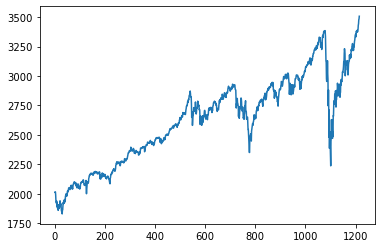

In [4]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/2000 until 12/31/2016.
start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2020, 8, 30)

price = data.DataReader(['sp500'], 'fred', start, end).ffill().bfill()
log_price = np.log(price)
log_price = log_price.values.flatten()
plt.plot(np.exp(log_price))

In [ ]:
sig=LPPL_confidence_signal(log_price=log_price, time=range(700,1200,20), time_windows=range(300,700,50))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


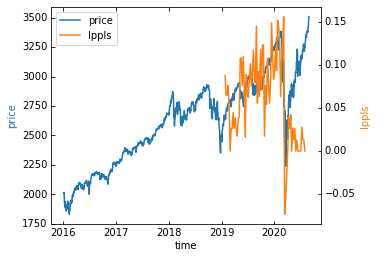

True

In [27]:
plot_lppls(log_price,sig,price.index)

In [23]:
sig=pd.read_csv('sig.csv',index_col=0)

In [24]:
sig

,0
800,0.087500
805,0.064935
810,0.064935
815,0.075949
820,0.050633
...,...
1175,0.000000
1180,0.027778
1185,0.013699
1190,0.012500


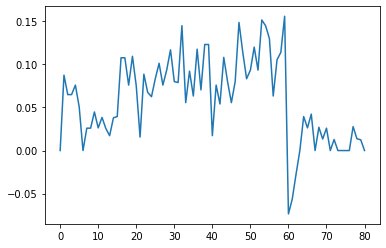

In [19]:
plt.plot(pd.DataFrame(sig)[1])

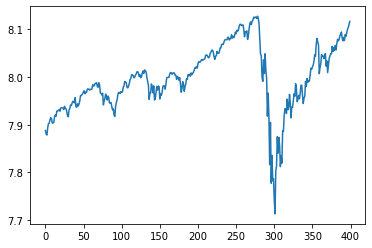

In [20]:
plt.plot(log_price[800:1200])